In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from torch.nn.functional import relu

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [30]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),                          
])

In [31]:
train_dataset = torchvision.datasets.SVHN(
    root='./data/train',
    split='train',
    transform=train_transforms,
    download=True,
)

test_dataset = torchvision.datasets.SVHN(
    root='./data/test',
    split='test',
    transform=test_transforms,
    download=True,
)

Using downloaded and verified file: ./data/train/train_32x32.mat
Using downloaded and verified file: ./data/test/test_32x32.mat


In [32]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
)

In [33]:
samples, labels = iter(train_loader).next()
print(samples.shape, labels.shape)

torch.Size([64, 3, 32, 32]) torch.Size([64])


In [34]:
train_size = len(train_dataset)
test_size = len(test_dataset)

print('Test size: ', test_size)
print('Train size: ', train_size)

Test size:  26032
Train size:  73257


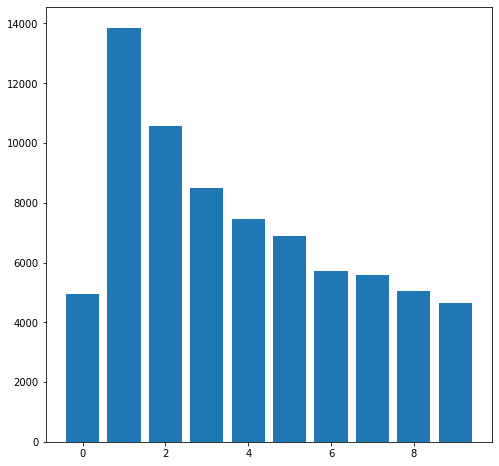

In [35]:
num_classes = 10
labels = torch.zeros(num_classes, dtype=torch.long)

for _, target in train_dataset:
    labels[target] += 1

plt.figure(figsize=(8,8))
plt.bar(x=[i for i in range(10)], height=labels.numpy())
plt.show()

In [36]:
class_mean = torch.mean(torch.Tensor.float(labels))
class_weights = (class_mean/labels).to(device)
print(class_weights)

tensor([1.4805, 0.5285, 0.6921, 0.8622, 0.9823, 1.0645, 1.2792, 1.3093, 1.4521,
        1.5724], device='cuda:0')


In [37]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.conv2 = nn.Conv2d(5, 7, 5)
        self.conv3 = nn.Conv2d(7, 10, 3)
        self.dropout = nn.Dropout(p=0.2)
        self.pool = nn.MaxPool2d(2, 2)
        self.l1 = nn.Linear(10*5*5, 512)
        self.l2 = nn.Linear(512, 10)

    def forward(self, x):
        out = relu(self.conv1(x))
        out = self.pool(relu(self.conv2(out)))
        out = self.dropout(out)

        out = self.pool(relu(self.conv3(out)))
        out = self.dropout(out)

        out = relu(self.l1(out.view(out.shape[0], -1)))
        out = self.l2(out)
        return out

    def get_train_metrics_dicts(self):
        return self.train_err_dict, self.train_acc_dict
    
    def get_test_metrics_dicts(self):
        return self.test_err_dict, self.test_acc_dict

    def get_learning_rate_dict(self):
        return self.lr_dict

    def fit(self, train_loader, test_loader, loss_function, optimizer, num_epochs, batch_size):
        self.train_err_dict, self.test_err_dict = {}, {}
        self.train_acc_dict, self.test_acc_dict = {}, {}
        self.lr_dict = {}

        for epoch in range(num_epochs):
            
            # save current learning rate
            self.lr_dict[epoch + 1] = optimizer.param_groups[0]['lr']

            # training step
            train_loss, train_correct = [], []

            model.train()
            for i, (x, y) in enumerate(train_loader):
                x = x.to(device)
                y = y.to(device)
                
                # forward pass
                y_hat = model(x)
                loss = loss_function(y_hat, y)

                # metrics update
                train_loss.append(loss.item())
                
                _, predictions = torch.max(y_hat, 1)
                train_correct.append((predictions == y).sum().item()) 

                # backward pass and weight update
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # calculate train metrics
            train_err = torch.mean(torch.tensor(train_loss)).item()
            train_acc = sum(train_correct)/(len(train_correct) * batch_size)
            self.train_err_dict[epoch + 1] = train_err
            self.train_acc_dict[epoch + 1] = train_acc

            # validation step
            model.eval()
            test_loss, test_correct = [], []

            with torch.no_grad():
                for i, (x, y) in enumerate(test_loader):
                    x = x.to(device)
                    y = y.to(device)

                    # forward pass 
                    y_hat = model(x)
                    loss = loss_function(y_hat, y)
                    
                    # metrics update
                    test_loss.append(loss.item())

                    _, predictions = torch.max(y_hat, 1)
                    test_correct.append((predictions == y).sum().item())
                
                # calculate train metrics
                test_err = torch.mean(torch.tensor(test_loss)).item()
                test_acc = sum(test_correct)/(len(test_correct) * batch_size)
                self.test_err_dict[epoch + 1] = test_err
                self.test_acc_dict[epoch + 1] = test_acc

            print('Epoch {}/{} - loss: {:.4f} - accuracy: {:.4f} - val_loss: {:.4f} - val_accuracy: {:.4f}'.format(epoch + 1, num_epochs,
                train_err, train_acc, test_err, test_acc))


model = NeuralNetwork().to(device)

In [39]:
model.fit(
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001),
    loss_function=nn.CrossEntropyLoss(weight=class_weights),
    num_epochs=40,
    batch_size=batch_size
)

Epoch 1/40 - loss: 0.9781 - accuracy: 0.6872 - val_loss: 0.6636 - val_accuracy: 0.7901
Epoch 2/40 - loss: 0.5948 - accuracy: 0.8195 - val_loss: 0.5226 - val_accuracy: 0.8409
Epoch 3/40 - loss: 0.5138 - accuracy: 0.8420 - val_loss: 0.4772 - val_accuracy: 0.8583
Epoch 4/40 - loss: 0.4701 - accuracy: 0.8575 - val_loss: 0.4554 - val_accuracy: 0.8635
Epoch 5/40 - loss: 0.4353 - accuracy: 0.8670 - val_loss: 0.4323 - val_accuracy: 0.8707
Epoch 6/40 - loss: 0.4132 - accuracy: 0.8740 - val_loss: 0.4221 - val_accuracy: 0.8757
Epoch 7/40 - loss: 0.3957 - accuracy: 0.8802 - val_loss: 0.3973 - val_accuracy: 0.8805
Epoch 8/40 - loss: 0.3785 - accuracy: 0.8850 - val_loss: 0.4055 - val_accuracy: 0.8808
Epoch 9/40 - loss: 0.3626 - accuracy: 0.8884 - val_loss: 0.3860 - val_accuracy: 0.8889
Epoch 10/40 - loss: 0.3514 - accuracy: 0.8924 - val_loss: 0.3829 - val_accuracy: 0.8885
Epoch 11/40 - loss: 0.3416 - accuracy: 0.8936 - val_loss: 0.3822 - val_accuracy: 0.8917
Epoch 12/40 - loss: 0.3336 - accuracy: 0.

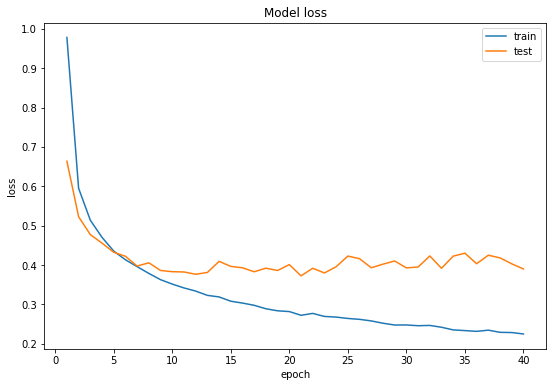

In [40]:
train_err_dict, train_acc_dict = model.get_train_metrics_dicts()
test_err_dict, test_acc_dict = model.get_test_metrics_dicts()

plt.figure(figsize=(9, 6))
plt.plot(list(train_err_dict.keys()), list(train_err_dict.values()))
plt.plot(list(test_err_dict.keys()), list(test_err_dict.values()))
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

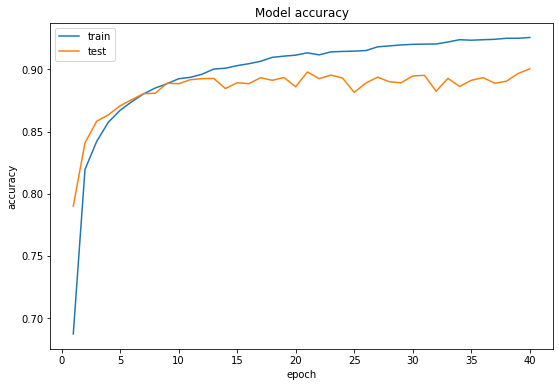

In [41]:
plt.figure(figsize=(9, 6))
plt.plot(list(train_acc_dict.keys()), list(train_acc_dict.values()))
plt.plot(list(test_acc_dict.keys()), list(test_acc_dict.values()))
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])
plt.show()